#Import Google Drive

In [1]:
#Problemi:
#1) non tutte le immagini hanno una valutazione (good, ok, bad, junk). Queste le ho scartate
#2) molte immagini di dimensione diversa
#3) trovate alcune immagini con label sbagliato

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#!unzip "/content/drive/MyDrive/paris.zip" -d "/content/drive/MyDrive/Paris120x120/"  > /dev/null

# Carica i file di Ground Truth

In [3]:
import os

good = set();
ok = set();
bad = set();
junk = set();

#groundtruth_dir = "/content/drive/My Drive/OxfordTxt/"
groundtruth_dir = "/content/drive/My Drive/gzp/"


#Itera i file txt nella directory
def leggi_ground_truth_files(directory):
  for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
      rank = filename.split("_")[-1] #la parte finale del nome del file
      if rank == "good.txt":
        leggi_file(f,good)
      elif rank == "ok.txt":
        leggi_file(f,ok)   
      elif rank == "bad.txt":
        leggi_file(f,bad)
      elif rank == "junk.txt":
        leggi_file(f,junk)
      #elif rank == "query.txt":
        #leggi_file(f,query)
  return;


def leggi_file(f, s):
  with open(f) as f:
    lines = f.readlines()
    for line in lines:
      #rimuovo il \n finale e aggiungo .jpg
      line = line[:len(line)-1] + ".jpg"
      s.add(line)
  return;

In [4]:
leggi_ground_truth_files(groundtruth_dir)
print("Numero di good: ", len(good))
print("Numero di ok: ", len(ok))
print("Numero di bad: ", len(bad))
print("Numero di junk: ", len(junk))

Numero di good:  0
Numero di ok:  1790
Numero di bad:  0
Numero di junk:  1619


#Carica DataSet

In [5]:
from PIL import Image
import numpy as np

class_names = ['paris_defense', 'paris_eiffel', 'paris_general', 'paris_invalides', 'paris_louvre', 'paris_moulinrouge',
                'paris_museedorsay', 'paris_notredame', 'paris_pantheon', 'paris_pompidou', 'paris_sacrecoeur', 'paris_triomphe' ]

dataset_dir='/content/drive/My Drive/Paris120x120/'

In [8]:
#Carica il dataset scartando le foto che non hanno una valutazione o ne hanno
#più di una
def carica_dataset_da_directory(dataset_dir):
  #cicla nelle entry della directory
  for filename in os.listdir(dataset_dir):
    f = os.path.join(dataset_dir, filename)
    # checking if it is a file
    if os.path.isfile(f):
      valutazione = carica_valutazione(filename);
      label = carica_label(filename)
      carica_foto(f, dataset, valutazione, label)
  return;


def carica_foto(f, dataset, valutazione, label):
  if label == -1 or valutazione < 0:
    return #foto senza valutazione o senza label, scartata

  img = Image.open(f)
  pix = np.array(img)/255
  formati.add(pix.shape)
  dataset[label][valutazione].append(pix)
  return;


def carica_label(filename):
  for i in range(len(class_names)):
    if(filename.startswith(class_names[i])):
      return i
  return -1


def carica_valutazione(filename):
  flag = 0
  x = [0,0,0,0] #flag per presenza di filename in good, ok, bad e junk
  if filename in good:
    x[0]=1
  if filename in ok:
    x[1]=1
  if filename in bad:
    x[2]=1
  if filename in junk:
    x[3]=1

  if sum(x) > 1:
    #print(filename, ": valutazioni discordanti")
    return -1
  if sum(x) == 0:
    #print(filename, ": valutazione non disponibile")
    return -2

  for i in range(4):
    if x[i] == 1:
      return i #0:good, 1:ok, 2:bad, 3:junk
  return 0;


#dataset[landmark][valutazione] = foto
dataset = [ [[],[],[],[]] for x in range(len(class_names))] 
formati = set()

carica_dataset_da_directory(dataset_dir)

In [9]:
from re import I
#FUNZIONI PER LA STAMPA DI STATISTICHE SUL DB
def dataset_len(dataset):
  n = 0
  for i in range(len(dataset)):
    for j in range(len(dataset[i])):
      n = n + len(dataset[i][j])
  return n;

def immagini_nei_landmark(dataset):
  v = np.zeros(len(dataset))
  for i in range(len(dataset)):
    for j in range(len(dataset[i])):
      v[i] = v[i] + len(dataset[i][j])
  return v;

def valutazioni_landmarks(dataset):
  v = [ [0,0,0,0] for x in range(len(dataset))]
  for i in range(len(dataset)):
    for j in range(len(dataset[i])):
      v[i][j] = len(dataset[i][j])
  return v;

def good_ok_bad_junk(dataset):
  x = valutazioni_landmarks(dataset)
  v = [0,0,0,0]
  for i in range(len(x)):
    for j in range(len(x[i])):
      v[j] = v[j] + x[i][j]
  return v

print("Numero immagini del dataset: ", dataset_len(dataset))
print("Numero di immagini nei vari landmark: ", immagini_nei_landmark(dataset))
print("Per ogni landmark, quanti sono quelli good, ok, bad e junk: ", valutazioni_landmarks(dataset))
print("Immagini good-ok-bad-junk: ", good_ok_bad_junk(dataset))
print("Numero di formati:", len(formati), formati)

Numero immagini del dataset:  3388
Numero di immagini nei vari landmark:  [232. 129. 683. 266. 249. 345.  90. 205. 319. 147. 279. 444.]
Per ogni landmark, quanti sono quelli good, ok, bad e junk:  [[0, 124, 0, 108], [0, 61, 0, 68], [0, 268, 0, 415], [0, 182, 0, 84], [0, 131, 0, 118], [0, 237, 0, 108], [0, 72, 0, 18], [0, 113, 0, 92], [0, 127, 0, 192], [0, 52, 0, 95], [0, 144, 0, 135], [0, 268, 0, 176]]
Immagini good-ok-bad-junk:  [0, 1779, 0, 1609]
Numero di formati: 2 {(120, 120, 3), (640, 640, 3)}


#Split dei dati in training, validation, test set

In [13]:
# per avere uno split equilibrato, esso avverrà secondo il seguente criterio:
# il training set sarà formato, per ogni landmark, dall' 80% del totale delle
# good per quel landmark + 80% del totale delle ok per quel landmark + ecc...
# il test set e il validation set avranno il 10% a testa

def split_dataset(dataset, x_train, x_val, x_test):

  for i in range(len(dataset)):
    for j in range(len(dataset[i])): 
      
      num_samples = len(dataset[i][j])

      train_len = round(0.8 * num_samples)
      x_train[i][j] = x_train[i][j] + dataset[i][j][:train_len]
      
      val_len = (num_samples - train_len) // 2
      x_val[i][j] = x_val[i][j] + dataset[i][j][train_len: train_len + val_len]

      test_len = (num_samples - train_len - val_len)
      x_test[i][j] = x_test[i][j] + dataset[i][j][-test_len:]

  return;

x_train = [ [[],[],[],[]] for x in range(len(class_names))]
x_val = [ [[],[],[],[]] for x in range(len(class_names))]
x_test = [ [[],[],[],[]] for x in range(len(class_names))]

split_dataset(dataset, x_train, x_val, x_test)

print(dataset_len(x_train))
print(dataset_len(x_val))
print(dataset_len(x_test))

2710
334
344


#Data Augmentation

In [ ]:
#eventuali trasformazioni

Training set examples


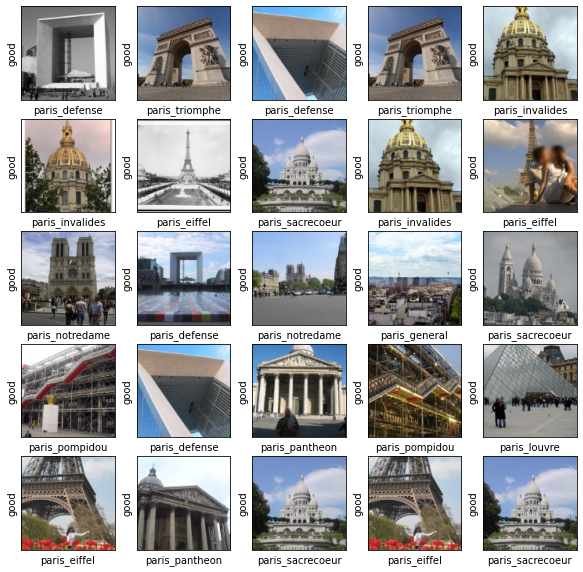

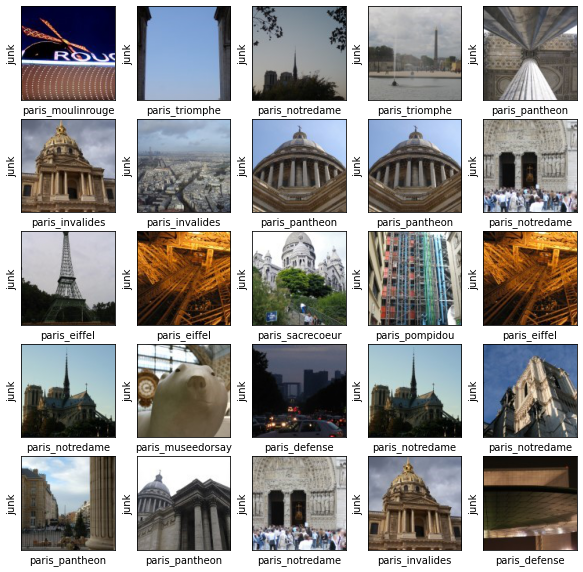

In [24]:
import matplotlib.pyplot as plt
import random

def stampa_esempi(val):
  plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.imshow(dataset[i], cmap=plt.cm.binary)
    landmark = random.randint(0, len(x_train)-1)
    index = random.randint(0, len(x_train[landmark])-1)
    plt.imshow(x_train[landmark][val][index], cmap=plt.cm.binary)
    plt.xlabel(class_names[landmark])
    if val == 1:
      plt.ylabel("good")
    if val == 3:
      plt.ylabel("junk")
  plt.show()
  return;

#Stampa esempi good
print("Training set examples")
stampa_esempi(1)
print("")
stampa_esempi(3)



#Creazione di Coppie

In [26]:
def make_pairs(x):
    """Crea coppie di immagini con label di corrispondenza

    Arguments:
        x è una lista avente la seguente struttura:
          - x[landmark][valutazione][immagine]

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """
    pairs = []
    labels = []

    num_classes = len(class_names)

    for i in range(len(x)):
      for j in range(len(x[i])):
        if j == 3:
          continue #salto i junk, non ha senso considerarli come buoni per le coppie
        for z in range(len(x[i][j])):

          # add a matching example
          label1 = i
          x1 = x[i][j][z]
          x2 = random.choice(x[i][1])

          pairs += [[x1, x2]]
          labels += [0]


          # add a non-matching example
          label2 = random.randint(0, num_classes - 1)
          while label2 == label1:
            label2 = random.randint(0, num_classes - 1)
          x2 = random.choice(x[label2][random.choice([1,3])])

          pairs += [[x1, x2]]
          labels += [1]
          
    return np.array(pairs), np.array(labels).astype("float32")

In [27]:
# make train, validation and test pairs
pairs_train, labels_train = make_pairs(x_train)
pairs_val, labels_val = make_pairs(x_val)
pairs_test, labels_test = make_pairs(x_test)

print(len(pairs_train), len(labels_train))
print(len(pairs_val), len(labels_val))
print(len(pairs_test), len(labels_test))

2848 2848
350 350
360 360


#Creazione Triplet

In [28]:
def make_triplet(x):
    triplets = []
    
    num_classes = len(class_names)

    for i in range(len(x)):
      for j in range(len(x[i])):
        if j == 3:
          continue #salto i junk, non ha senso considerarli come buoni per le coppie
        for z in range(len(x[i][j])):

          # x2 is matching example
          label1 = i
          x1 = x[i][j][z]
          x2 = random.choice(x[i][1])

          # x3 is non-matching example
          label2 = random.randint(0, num_classes - 1)
          while label2 == label1:
            label2 = random.randint(0, num_classes - 1)
          x3 = random.choice(x[label2][random.choice([1,3])])

          triplets += [[x1, x2, x3]]
          
    return np.array(triplets)

In [29]:
# make train, validation and test triplet
triplet_train = make_triplet(x_train)
triplet_val = make_triplet(x_val)
triplet_test = make_triplet(x_test)

print(len(triplet_train))
print(len(triplet_val))
print(len(triplet_test))

1424
175
180


#Definizione del modello (Binario) (PROVVISORIO)

In [41]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras


# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((120, 120, 3))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((120, 120, 3))
input_2 = layers.Input((120, 120, 3))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)



In [42]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


In [43]:
epochs = 10
batch_size = 16
margin = 1  # Margin for constrastive loss.

siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

print(pairs_train.shape)

x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]


print(x_train_1.shape)
print(x_train_2.shape)



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_9 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_3 (Functional)           (None, 10)           165238      ['input_8[0][0]',                
                                                                  'input_9[0][0]']          

In [44]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)


Epoch 1/10
178/178 [==============================] - 108s 593ms/step - loss: 0.2939 - accuracy: 0.5428 - val_loss: 0.2921 - val_accuracy: 0.5514
Epoch 2/10
178/178 [==============================] - 102s 573ms/step - loss: 0.2772 - accuracy: 0.5467 - val_loss: 0.2717 - val_accuracy: 0.5200
Epoch 3/10
178/178 [==============================] - 103s 581ms/step - loss: 0.2592 - accuracy: 0.5614 - val_loss: 0.2469 - val_accuracy: 0.5829
Epoch 4/10
178/178 [==============================] - 101s 565ms/step - loss: 0.2595 - accuracy: 0.5383 - val_loss: 0.2417 - val_accuracy: 0.5943
Epoch 5/10
178/178 [==============================] - 101s 568ms/step - loss: 0.2513 - accuracy: 0.5446 - val_loss: 0.2397 - val_accuracy: 0.5771
Epoch 6/10
178/178 [==============================] - 101s 570ms/step - loss: 0.2491 - accuracy: 0.5428 - val_loss: 0.2389 - val_accuracy: 0.5629
Epoch 7/10
178/178 [==============================] - 102s 571ms/step - loss: 0.2461 - accuracy: 0.5541 - val_loss: 0.2430 -

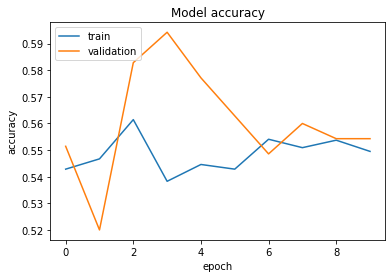

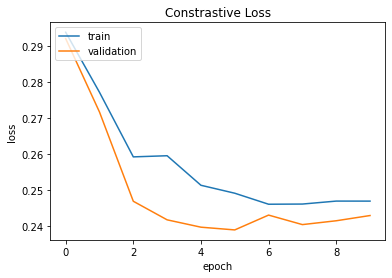

In [45]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")
